In [6]:
import torch 
from torch import nn, Tensor
from typing import Union, Tuple
import torchvision
from torchvision.transforms import v2 
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import random
import os
from model import Model 
# import math
import pickle

seed_number = 42
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
np.random.seed(seed_number)
os.environ['PYTHONHASHSEED'] = str(seed_number)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64 


In [2]:

def downloadData(batch_size, download=True):


    transforms = v2.Compose(
        [
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Grayscale(1),
            v2.Normalize((0.5, ), (0.5, ))
        ]
    )

    trainset = torchvision.datasets.MNIST('./', train=True, transform=transforms, download=download)
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [0.9, 0.1], generator=torch.Generator().manual_seed(42)
    )

    testset = torchvision.datasets.MNIST('./', train=False, transform=transforms, download=download)
        
    train_data = torch.utils.data.DataLoader(train_subset,  batch_size=batch_size, shuffle=True, num_workers=2)
    test_data = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_data = torch.utils.data.DataLoader(val_subset,  batch_size=batch_size, shuffle=True, num_workers=2)
    return train_data, val_data, test_data

def calculateAccuracy(predicted, targets):
    predicted = nn.functional.softmax(predicted, dim=0)    
    pred_no = torch.argmax(predicted, dim=1)
    # print(predicted)
    right = torch.sum(torch.eq(pred_no, targets).int())
    return right / len(pred_no)


def test(testIter, model, device=device):
    with torch.no_grad():
        model.eval()
        acc_batch = []
        for _, (X, y) in enumerate(tqdm(testIter)):
            X, y = X.to(device), y.to(device)
            out = model(X)
            a = calculateAccuracy(out, y)
            acc_batch.append(a.item())
    total_acc = sum(acc_batch) / len(acc_batch)
    return total_acc

In [3]:
_, _, testIter = downloadData(BATCH_SIZE, download=False)

In [ ]:
model = Model()
model.load_state_dict(torch.load("prunedModels/90percent.pth", map_location='cpu'))
test(testIter=testIter, model=model, device=device)

In [29]:
import seaborn as ss
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pickle
%matplotlib inline


In [63]:

# plt.style.use('classic')
def getTestAccuracy():
    files = os.listdir('./logs')
    acc_list = {}
    for f in files:
        weights = os.path.join('./prunedModels', f + '.pth')
        model = Model()
        model.load_state_dict(torch.load(weights, map_location='cpu'))
        acc = test(testIter=testIter, model=model, device=device)
        f = f.rstrip('percent')
        acc_list[int(f)] = acc
    return acc_list



In [57]:
def getPercentage():
    files = os.listdir('./logs')
    acc_list = {}
    base_model = Model()
    base_model.load_state_dict(torch.load('./prunedModels/0percent.pth', map_location=device))
    n_wghts_base = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    print(n_wghts_base)
    for f in files:
        if f != "0percent":
            masks = os.path.join('./masks/', f + "Masks" )
            with open(masks, 'rb') as fp:
                m = pickle.load(fp)
            # print(m)
            # break
            # model = Model()
            # model.load_state_dict(torch.load(weights, map_location='cpu'))
            # n_wghts = sum(p.numel() for p in model.parameters() if p.requires_grad)
            n_wghts = sum([x.sum() for x in m])
            # print(n_wghts)
            # acc = test(testIter=testIter, model=model, device=device)
            f = f.rstrip('percent')
            acc_list[int(f)] = (100 - ((n_wghts/n_wghts_base) * 100)).numpy()
            # acc_list
    return acc_list

In [58]:
act_percent = getPercentage()

2689344


In [59]:
print(act_percent)

{10: array(11.414642, dtype=float32), 14: array(15.72673, dtype=float32), 18: array(20.487305, dtype=float32), 25: array(28.179848, dtype=float32), 30: array(33.73314, dtype=float32), 3: array(2.999649, dtype=float32), 40: array(43.976448, dtype=float32), 4: array(4.4139023, dtype=float32), 50: array(53.95959, dtype=float32), 5: array(5.6304016, dtype=float32), 60: array(63.627155, dtype=float32), 6: array(6.861824, dtype=float32), 70: array(73.37927, dtype=float32), 7: array(8.002434, dtype=float32), 80: array(82.49368, dtype=float32), 8: array(9.13929, dtype=float32), 90: array(91.78706, dtype=float32), 95: array(97.158936, dtype=float32), 96: array(98.330185, dtype=float32), 97: array(99.498276, dtype=float32), 98: array(99.962555, dtype=float32), 99: array(99.995316, dtype=float32)}


In [64]:
accuracy_list = getTestAccuracy()

100%|██████████| 157/157 [00:01<00:00, 103.08it/s]


In [126]:
def plotAcc(acc_list, percent):
    ss.set_context('paper')
    ss.set_style("whitegrid")
    # ss.set_style("ticks")
    
    acc_list = dict(sorted(acc_list.items()))
    print(acc_list)
    # ss.scatterplot(acc_list)
    x = []
    x.append(np.array(0))
    for i in acc_list.keys():
        if i != 0:
            x.append(percent[i])
    plt.plot(x, acc_list.values() )
    plt.xlabel('Percentage Pruned')
    plt.ylabel('Test Accuracy')
    for key, value in acc_list.items():
        if key != 0:
            plt.plot(percent[key], value, 'ko')
            plt.plot([percent[key], percent[key]], [0, value], 'k:')
    plt.plot(0, acc_list[0], 'ko' )
    plt.plot([0, 0], [0, acc_list[0]], 'k:')
    
    # plt.legend()
    plt.ylim(0, 1.0)
    plt.yticks([acc_list[0]] + list(plt.yticks()[0])  )
    plt.xticks([i for i in range(0, 105, 5)])
    plt.axline((0, acc_list[0]), (105, acc_list[0]), linestyle='--', color='red' )
    plt.xlim(-1, 102)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    # plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False) 
    plt.show()

{0: 0.9314291401273885, 3: 0.90734474522293, 4: 0.9136146496815286, 5: 0.9220740445859873, 6: 0.9260549363057324, 7: 0.9175955414012739, 8: 0.9279458598726115, 10: 0.9079418789808917, 14: 0.9258558917197452, 18: 0.9209792993630573, 25: 0.926453025477707, 30: 0.9421775477707006, 40: 0.9222730891719745, 50: 0.9167993630573248, 60: 0.9198845541401274, 70: 0.9262539808917197, 80: 0.897093949044586, 90: 0.8638535031847133, 95: 0.8594745222929936, 96: 0.7616441082802548, 97: 0.40346337579617836, 98: 0.09783041401273886, 99: 0.09783041401273886}


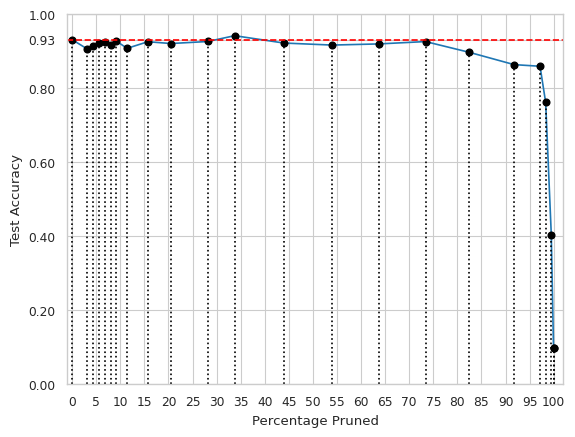

In [127]:
plotAcc(accuracy_list, act_percent)

In [131]:
def plotTrainingLoss():
    files_re = ['0percent', '70percent', '30percent', '3percent', '95percent']
    # print(files_re)
    line_styles = ['--', ':', '-', '-.', '-o', '-x']
    j = 0
    for f in files_re:
        with open(os.path.join('./logs', f), 'rb') as fp:
            logs = pickle.load(fp)
        loss = logs['trainingLoss']
        # plt.plot(loss[0])
        loss_ = []
        for l in loss:
            for i in range(len(l)):
                if i % 800 == 0:
                    loss_.append(l[i])
                    # print(l[i])
        # print(len(loss_))
        plt.plot(loss_, line_styles[j], label=f.rstrip("percent") + "%")
        plt.xlabel("Epochs")
        plt.ylabel("Cross Entropy Loss")
        plt.xlim(0, 10)
        j+=1
        plt.legend()
        # print()
        
def plotTrainingAcc():
    files_re = ['0percent', '70percent', '30percent', '3percent', '95percent']
    # print(files_re)
    line_styles = ['--', ':', '-', '-.', '-o', '-x']
    j = 0
    for f in files_re:
        with open(os.path.join('./logs', f), 'rb') as fp:
            logs = pickle.load(fp)
        loss = logs['trainingAccuracy']
        # plt.plot(loss[0])
        loss_ = []
        for l in loss:
            for i in range(len(l)):
                if i % 800 == 0:
                    loss_.append(l[i])
                    # print(l[i])
        # print(len(loss_))
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.xlim(0, 10)
        plt.plot(loss_, line_styles[j], label=f.rstrip("percent") + "%")
        j+=1
        plt.legend()

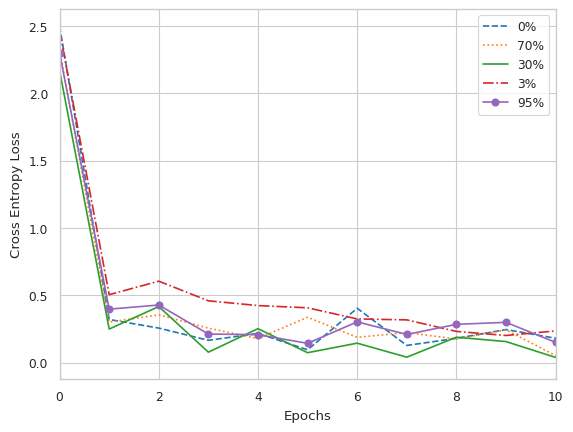

In [132]:
plotTrainingLoss()

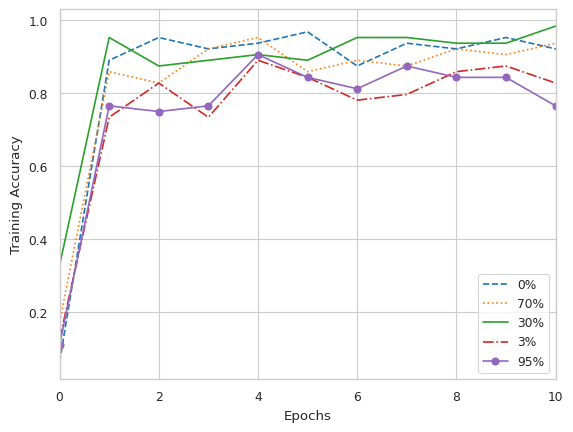

In [133]:
plotTrainingAcc()